In [34]:
import os
import keras
import numpy as np
from tqdm import tqdm 
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array 
import matplotlib.pyplot as plt

# Load Data

data ---
https://www.kaggle.com/code/utkarshsaxenadn/pix2pixgan-map-generator/notebook

In [35]:
def load_data(path, trim=None):
  paths = sorted(glob(path + "*.jpg"))
    
  if trim is not None:
    paths = sorted(glob(path + "*.jpg"))[:trim]
      
  images = np.zeros(shape=(len(paths), 256, 256, 3))
  masks = np.zeros(shape=(len(paths), 256, 256, 3))
    
  for i,path in tqdm(enumerate(paths), desc="Data"):
      image = tf.cast(img_to_array(load_img(path)), tf.float32)
      img = image[:,:600,:]
      mask = image[:,600:,:]
      images[i] = tfi.resize(img,(256,256))/255.
      masks[i] = tfi.resize(mask,(256,256))/255.
  return images, masks

def show_image(image, title=None, alpha=1.0):
  plt.imshow(image, alpha=alpha)
  if title is not None:
    plt.title(title)
  plt.axis("off")

def show_mask(image, mask, alpha=0.4, title=None):
  image = tf.squeeze(tf.cast(image, tf.float32))
  mask = tf.squeeze(tf.cast(mask, tf.float32))
  show_image(image)
  show_image(mask, alpha=alpha, title=title)

In [36]:
# trim dataset to avoid ram issues
dataset = load_data('Data\\maps\\train\\', trim=1000)
images, masks = dataset

Data: 1000it [00:20, 49.65it/s]


In [37]:
data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

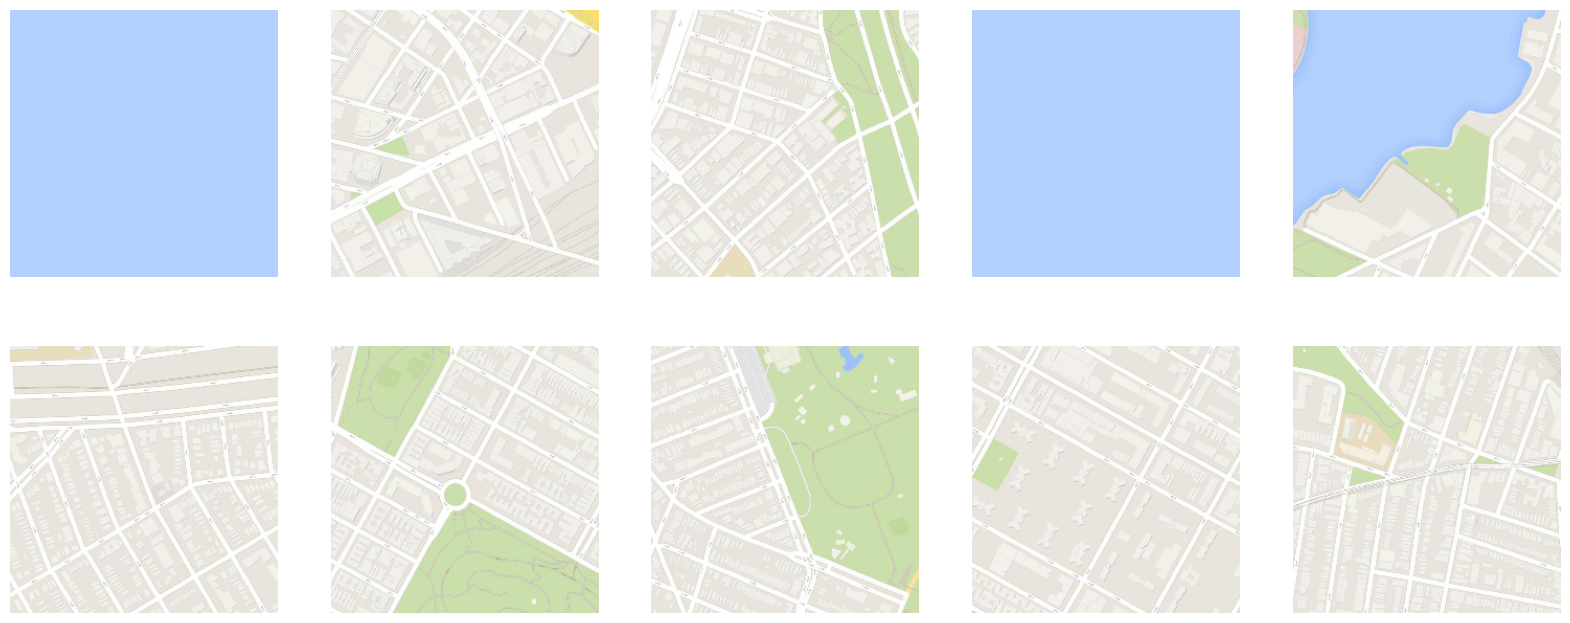

In [38]:
for images, masks in data.take(1):
    sample_images = images
    sample_masks = masks
    break

plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_image(sample_masks[i])

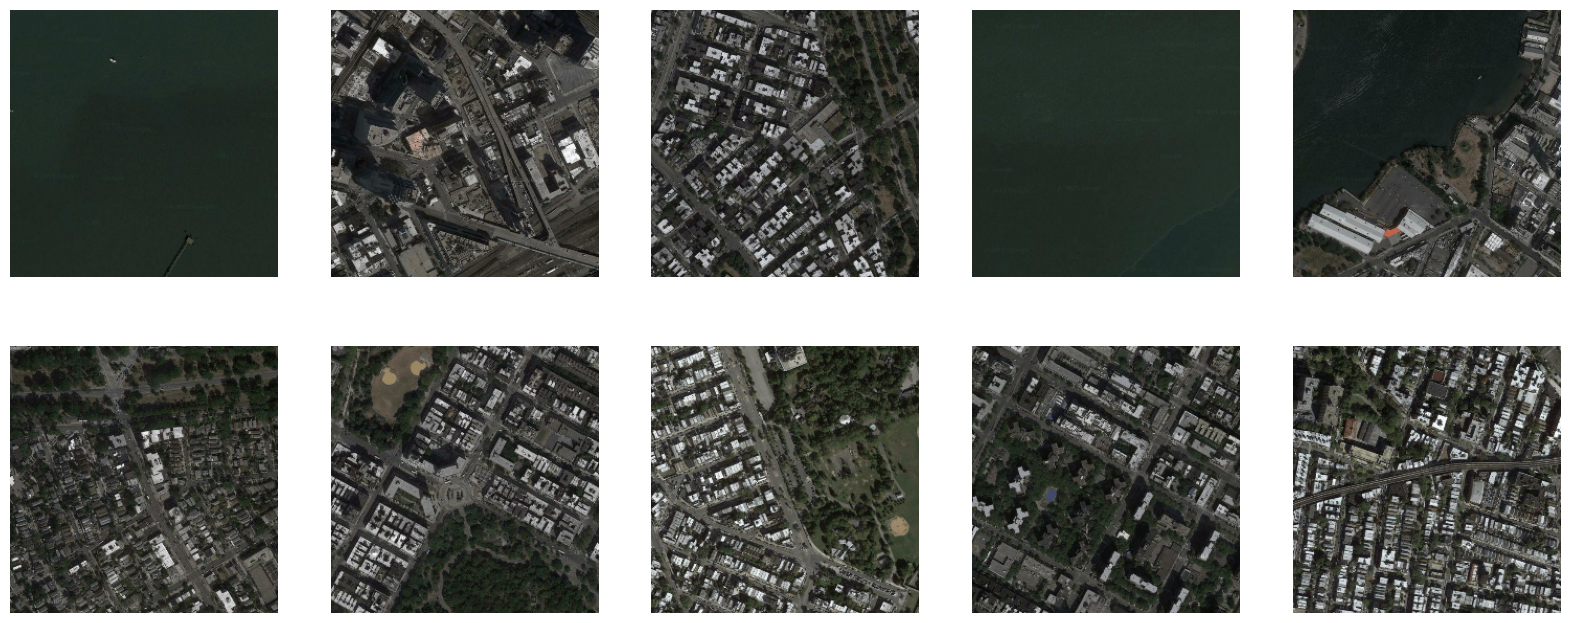

In [39]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_image(sample_images[i])

# Upsample and Downsample functions

In [40]:
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.layers import Conv2DTranspose

from keras.initializers import RandomNormal
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model, load_model

# Model Viz
from tensorflow.keras.utils import plot_model

# Model Losses
from keras.losses import BinaryCrossentropy

def downsample(filters, size, batch_norm=True):
    
  layer = Sequential()
  layer.add(Conv2D(filters, kernel_size=size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
  if batch_norm:
      layer.add(BatchNormalization())
  layer.add(LeakyReLU())
  
  return layer

def upsample(filters, size, dropout=False):
  layer = Sequential()
  layer.add(Conv2DTranspose(filters, kernel_size=size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
  layer.add(BatchNormalization())
  if dropout:
      layer.add(Dropout(0.5))
  layer.add(ReLU())
  return layer


# Create the Generator
## The generator is a series of upsampling and downsampling ...

In [41]:
def Generator1():

  inputs = Input(shape=(256,256,3)) 

  downsample_stack = [
    downsample(64, 4, batch_norm=False), # why is batch false here
    downsample(128, 4), 
    downsample(256, 4), 
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4)
    ]

  upsample_stack=[
    upsample(512, 4,dropout=True),
    upsample(512, 4,dropout=True),
    upsample(512, 4,dropout=True), # why is dropout true here
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4),
    ]
  
  last = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh', kernel_initializer=tf.random_normal_initializer(0.,0.02))

  x = inputs
  skips = []
  for down in downsample_stack: 
    x = down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])
  for up, skip, in zip(upsample_stack, skips):
    x = up(x)
    x = concatenate([x, skip])
  
  x = last(x)
  return Model(inputs=inputs, outputs=x)

In [42]:
generator1 = Generator1()
generator1.summary()

Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_48       │ (None, 128, 128,  │      3,072 │ input_layer_46[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_49       │ (None, 64, 64,    │    131,584 │ sequential_48[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_50       │ (None, 32, 32,    │    525,312 │ sequential_49[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_51       │ (None, 16, 16,    │  2,099,200 │ sequential_50[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 8, 8, 512) │  4,196,352 │ sequential_51[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_53       │ (None, 4, 4, 512) │  4,196,352 │ sequential_52[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_54       │ (None, 2, 2, 512) │  4,196,352 │ sequential_53[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_55       │ (None, 1, 1, 512) │  4,196,352 │ sequential_54[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_56       │ (None, 2, 2, 512) │  4,196,352 │ sequential_55[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 2, 2,      │          0 │ sequential_56[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_54[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_57       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_16[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 4, 4,      │          0 │ sequential_57[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_53[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_58       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_17[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 8, 8,      │          0 │ sequential_58[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_52[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_59       │ (None, 16, 16,    │  8,390,656 │ concatenate_18[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 16, 16,    │          0 │ sequential_59[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [43]:
class Generator:
  def __init__(self):
    inputs = Input(shape=(256, 256, 3))
    downsample_stack = [
      downsample(64, 4, batch_norm=False), # why is batch false here
      downsample(128, 4), 
      downsample(256, 4), 
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4)]
    
    upsample_stack=[
      upsample(512, 4,dropout=True),
      upsample(512, 4,dropout=True),
      upsample(512, 4,dropout=True), # why is dropout true here
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
      ]
  
    last = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh', kernel_initializer=tf.random_normal_initializer(0.,0.02))

    x = inputs
    skips = []
    for down in downsample_stack: 
      x = down(x)
      skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip, in zip(upsample_stack, skips):
      x = up(x)
      x = concatenate([x, skip])
    
    x = last(x)
    self.model = Model(inputs=inputs, outputs=x)

In [44]:
generator = Generator()
generator.model.summary()

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_63       │ (None, 128, 128,  │      3,072 │ input_layer_62[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_64       │ (None, 64, 64,    │    131,584 │ sequential_63[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_65       │ (None, 32, 32,    │    525,312 │ sequential_64[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_66       │ (None, 16, 16,    │  2,099,200 │ sequential_65[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_67       │ (None, 8, 8, 512) │  4,196,352 │ sequential_66[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_68       │ (None, 4, 4, 512) │  4,196,352 │ sequential_67[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_69       │ (None, 2, 2, 512) │  4,196,352 │ sequential_68[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_70       │ (None, 1, 1, 512) │  4,196,352 │ sequential_69[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_71       │ (None, 2, 2, 512) │  4,196,352 │ sequential_70[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_23      │ (None, 2, 2,      │          0 │ sequential_71[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_69[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_72       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_23[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 4, 4,      │          0 │ sequential_72[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_68[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_73       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_24[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 8, 8,      │          0 │ sequential_73[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_67[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_74       │ (None, 16, 16,    │  8,390,656 │ concatenate_25[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 16, 16,    │          0 │ sequential_74[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

Random testin

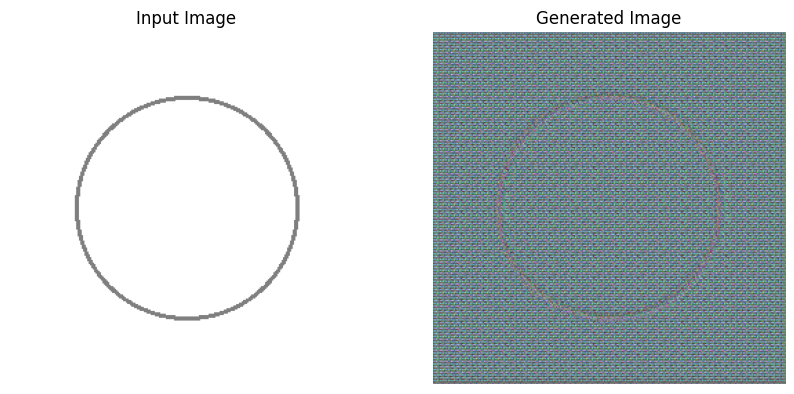

In [45]:
test_input = np.ones((256, 256, 3), dtype=np.float32)

# Define the circle's parameters
center = (128, 128)
radius = 80
color = (0, 0, 0)
for y in range(256):
    for x in range(256):
        if abs(np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) - radius) < 1.5:
            test_input[y, x] = color
test_input = tf.expand_dims(test_input, axis=0)

generated_image = generator.model(test_input, training=False)

# # Remove the batch dimension and normalize values to [0, 1]
test_input = (test_input[0] + 1) / 2  # Normalizing from [-1, 1] to [0, 1]
generated_image = (generated_image[0] + 1) / 2  # Normalizing from [-1, 1] to [0, 1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(test_input.numpy())
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_image.numpy())
plt.axis("off")

plt.show()

# Create Discriminator


In [46]:
class Discriminator:
  def __init__(self):
    init = tf.random_normal_initializer(0.,0.02)
    input = Input(shape=(256,256,3), name="input_image")
    target = Input(shape=(256,256,3), name="target)image")

    x = concatenate([input, target])
    x = downsample(64, 4, batch_norm=False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    
    x = ZeroPadding2D()(x)
    x = Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = ZeroPadding2D()(x)
    
    x = Conv2D(1, 4, kernel_initializer=init)(x)
    self.model = Model(inputs=[input, target], outputs=[x])


In [47]:
discriminator = Discriminator()
discriminator.model.summary()

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target)image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target)image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_78       │ (None, 128, 128,  │      6,144 │ concatenate_30[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_79       │ (None, 64, 64,    │    131,584 │ sequential_78[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_80       │ (None, 32, 32,    │    525,312 │ sequential_79[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ sequential_80[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d_2… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_47      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 33, 33,    │          0 │ leaky_re_lu_47[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_3… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

Testing discriminator

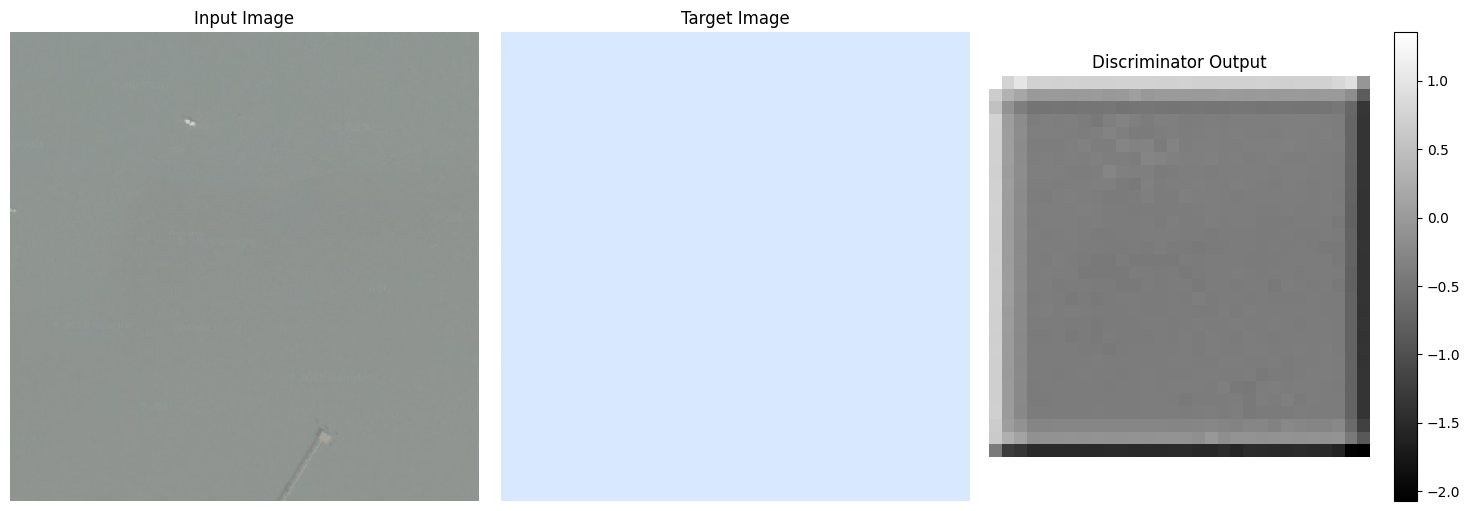

In [48]:
input_test = sample_images[0]
target_test = sample_masks[0]

input_test = tf.expand_dims(input_test, axis=0)
target_test = tf.expand_dims(target_test, axis=0)

discriminator_output = discriminator.model([input_test, target_test], training=False)[0]


input_test = (input_test[0] + 1) / 2
target_test = (target_test[0] + 1) / 2

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_test)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Target Image")
plt.imshow(target_test)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Discriminator Output")
plt.imshow(discriminator_output.numpy(), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()


Discriminator is random so output is all over the place

# Loss Functions 


In [49]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, generated_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
  return real_loss + generated_loss

def generator_loss(generated_output, gen_output, target):
    adv_loss = cross_entropy(tf.ones_like(generated_output), generated_output)  # Fool the discriminator
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return adv_loss + (100 * l1_loss)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Define training function

In [50]:
def display_samples(epoch, input_images, target_images, generated_images):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display the first image from the batch (index 0)
    axes[0].imshow(input_images[0])
    axes[1].imshow(target_images[0])
    axes[2].imshow(generated_images[0])
    
    # Set titles for each subplot
    axes[0].set_title("Input Image")
    axes[1].set_title("Target Image")
    axes[2].set_title("Generated Image")
    
    plt.show()


In [57]:
def update_disc_gen(input_image, target_image):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # generate an image based on input
    generated_image = generator.model(input_image, training=True)

    # discriminator outputs one for input and target and one for input and generated image
    real_output = discriminator.model([input_image, target_image], training=True)
    generated_output_disc = discriminator.model([input_image, generated_image], training=True)

    # calculate the loss of thee generator and the discriminator
    gen_loss = generator_loss(generated_output_disc, generated_image, target_image)
    disc_loss = discriminator_loss(real_output, generated_output_disc)

  # get gradient loss
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.model.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.model.trainable_variables)

  # apply the gradient loss to the variables
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.model.trainable_variables))

  return gen_loss, disc_loss

def train(dataset, epochs):
  for epoch in range(epochs):
    for input_image, target_image in dataset:
      gen_loss, disc_loss = update_disc_gen(input_image, target_image)

      print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

      # print samples of training images
      if ((epoch) % 10 == 0):
        sample_image = generator.model(input_image, training=False)
        display_samples(epoch, [input_image[0]], [target_image[0]], [sample_image[0]])

In [55]:
# preprocess image data
def preprocess(input_image, target_image):
  input_image = tf.image.resize(input_image, [256, 256])
  target_image = tf.image.resize(target_image, [256, 256])
  return input_image, target_image


data = (
    tf.data.Dataset.from_tensor_slices((images, masks))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


Epoch 1, Gen Loss: 76.72571563720703, Disc Loss: 1.0700249671936035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


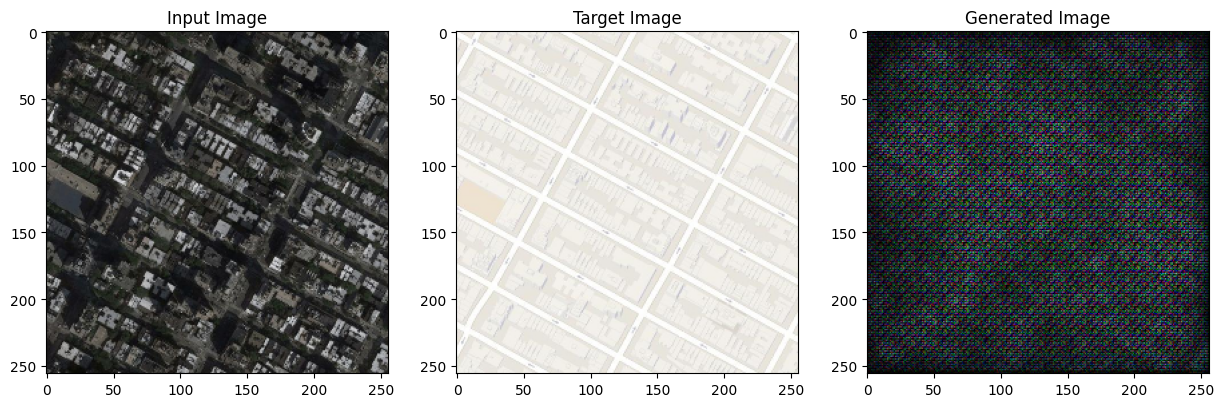

Epoch 2, Gen Loss: 73.89315795898438, Disc Loss: 0.9669650793075562
Epoch 3, Gen Loss: 71.10892486572266, Disc Loss: 0.913702130317688
Epoch 4, Gen Loss: 68.33580017089844, Disc Loss: 0.8632423877716064
Epoch 5, Gen Loss: 65.62346649169922, Disc Loss: 0.8823051452636719
Epoch 6, Gen Loss: 62.84333801269531, Disc Loss: 0.8527562618255615
Epoch 7, Gen Loss: 60.07123947143555, Disc Loss: 0.7202918529510498
Epoch 8, Gen Loss: 57.297508239746094, Disc Loss: 0.6758698225021362
Epoch 9, Gen Loss: 54.60002899169922, Disc Loss: 0.6627561450004578
Epoch 10, Gen Loss: 51.98691177368164, Disc Loss: 0.682724118232727
Epoch 11, Gen Loss: 49.39653778076172, Disc Loss: 0.6997514367103577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


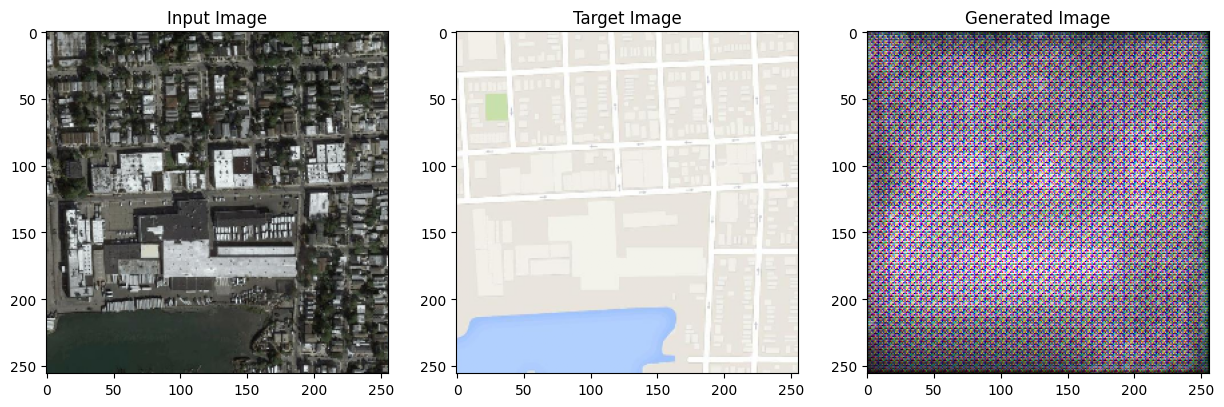

Epoch 12, Gen Loss: 46.85014724731445, Disc Loss: 0.7424694299697876
Epoch 13, Gen Loss: 44.27518844604492, Disc Loss: 0.7123298645019531
Epoch 14, Gen Loss: 41.899471282958984, Disc Loss: 0.6725426912307739
Epoch 15, Gen Loss: 39.790042877197266, Disc Loss: 0.7225242853164673
Epoch 16, Gen Loss: 37.73225784301758, Disc Loss: 0.6722912788391113
Epoch 17, Gen Loss: 35.05049133300781, Disc Loss: 0.6545053124427795
Epoch 18, Gen Loss: 33.108734130859375, Disc Loss: 0.6917543411254883
Epoch 19, Gen Loss: 31.224058151245117, Disc Loss: 0.6333434581756592
Epoch 20, Gen Loss: 29.277124404907227, Disc Loss: 0.6329660415649414


In [58]:
train(data, 20)

Epoch 1, Gen Loss: 27.462244033813477, Disc Loss: 0.675268292427063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


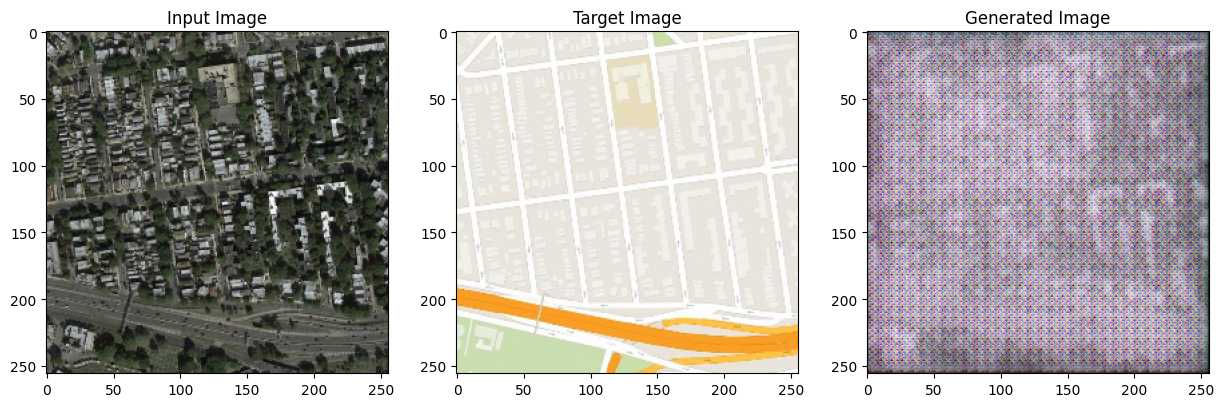

Epoch 2, Gen Loss: 26.100051879882812, Disc Loss: 0.8911938071250916
Epoch 3, Gen Loss: 24.515775680541992, Disc Loss: 1.108905553817749
Epoch 4, Gen Loss: 22.976924896240234, Disc Loss: 0.7342973947525024
Epoch 5, Gen Loss: 21.675668716430664, Disc Loss: 0.7285499572753906
Epoch 6, Gen Loss: 20.296743392944336, Disc Loss: 0.6608568429946899
Epoch 7, Gen Loss: 19.104015350341797, Disc Loss: 0.6614218950271606
Epoch 8, Gen Loss: 18.0601863861084, Disc Loss: 0.6560289263725281
Epoch 9, Gen Loss: 17.124286651611328, Disc Loss: 0.6414059400558472
Epoch 10, Gen Loss: 16.016101837158203, Disc Loss: 0.6622804403305054
Epoch 11, Gen Loss: 15.56320571899414, Disc Loss: 0.6747462749481201


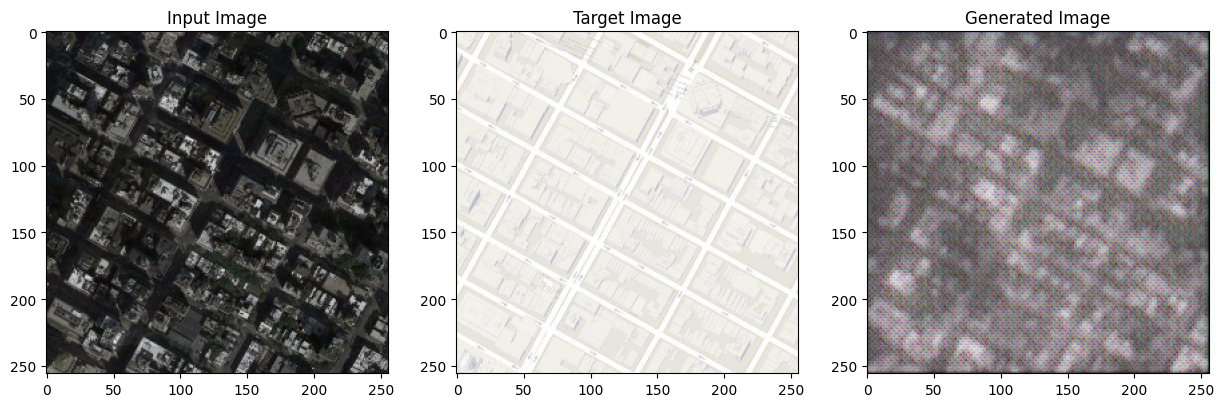

Epoch 12, Gen Loss: 13.968918800354004, Disc Loss: 0.8539397716522217
Epoch 13, Gen Loss: 14.847238540649414, Disc Loss: 1.0818907022476196
Epoch 14, Gen Loss: 12.731356620788574, Disc Loss: 1.099238395690918
Epoch 15, Gen Loss: 12.725751876831055, Disc Loss: 0.8977490663528442
Epoch 16, Gen Loss: 12.24924087524414, Disc Loss: 0.7036389112472534
Epoch 17, Gen Loss: 11.181092262268066, Disc Loss: 0.7630169987678528
Epoch 18, Gen Loss: 11.008182525634766, Disc Loss: 0.7646552324295044
Epoch 19, Gen Loss: 10.49020767211914, Disc Loss: 0.9559893012046814
Epoch 20, Gen Loss: 9.589503288269043, Disc Loss: 0.8791780471801758
Epoch 21, Gen Loss: 10.536669731140137, Disc Loss: 0.7785736918449402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


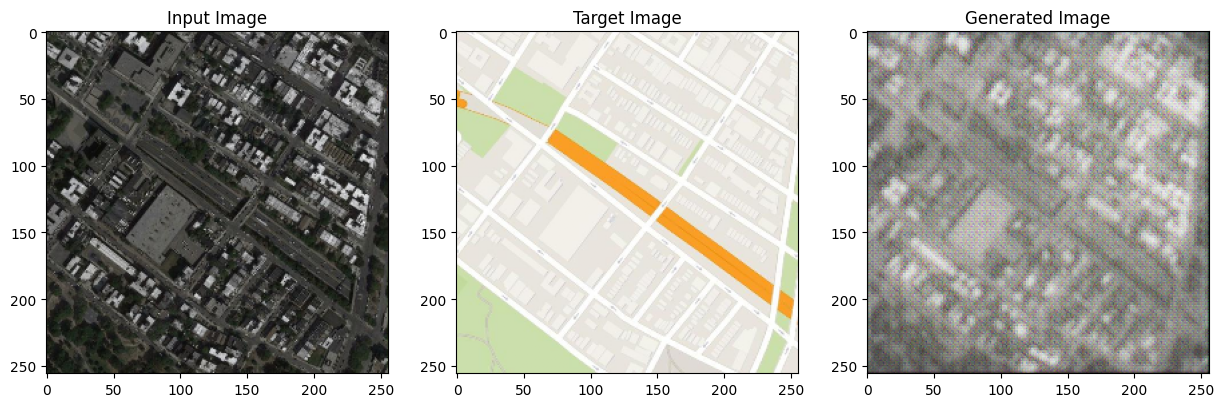

In [59]:
train(data, 21)